In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Flatten, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *

In [5]:
nlp = spacy.load('en_core_web_lg')

df = pd.read_csv('TrainingDS.csv')
df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
df.head()

,ID,Text,Class
0,1,Trump supporters needed to say the 4 Democrats...,0
1,2,Send them back!!Why the hell are they even her...,1
2,3,Yeah...Im wondering if send them back works fo...,1
3,4,I know you realize you cant pretend that you d...,1
4,5,"Donny, you owe all people an apology for appla...",0


In [6]:
df = pd.read_csv('TrainingDS.csv')
prep_train = PrepareText(df, spell_correct=True, remove_punct=False)
prep_train.prepare()
prep_train.save_file('prep_train.csv')
df = prep_train.df

df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
prep_test = PrepareText(df_test, spell_correct=True, remove_punct=False)
prep_test.prepare()
prep_test.save_file('prep_test.csv')
df_test = prep_test.df
df.head()

preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL
preparing
TO_LOWER
REMOVE_EMOJI
REMOVE_EMOTICONS
CHAT_WORDS_CONVERSION
SPELL_CORRECT
ADD_SPACE
REMOVE_STOPWORDS
REMOVE_URL


,ID,Text,Class
0,1,trump supporters needed 4 democrats socialist ...,0
1,2,send back!!why hell im sick hearing ifwe great...,1
2,3,yeah... im wondering send works wife camp 3 kn...,1
3,4,know realize cant pretend didnt know obama beg...,1
4,5,donny owe people apology applauding horrible c...,0


In [7]:
X_train, y_train = df['Text'], df['Class']

In [8]:
maxlen = 50
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [9]:
tokenizer.fit_on_texts(X_train)

In [10]:
sequences = tokenizer.texts_to_sequences(X_train)

In [11]:
index = 0
print(X_train[index])
print(sequences[index])

trump supporters needed 4 democrats socialist squad racist trump america supporters america freedom speech trump hyper rally socialist democratic squad rally rally said send migrants socialist democratic
[2, 23, 1014, 90, 60, 235, 78, 4, 2, 56, 23, 56, 540, 236, 2, 2272, 7, 235, 288, 78, 7, 7, 16, 1, 1015, 235, 288]


In [12]:
X_train = pad_sequences(sequences, maxlen=maxlen)

In [13]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    2,   23, 1014,   90,   60,  235,   78,    4,    2,   56,
          23,   56,  540,  236,    2, 2272,    7,  235,  288,   78,    7,
           7,   16,    1, 1015,  235,  288],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1,   71, 1413,  166,  111,  466,  322, 2273,
        1016,   13, 1016,  198,  366,  467,  185,  167, 2274,  199,  468,
        2275,   14,    2,  200,   40, 2276]])

In [73]:
model = Sequential()
model.add(Embedding(num_words, 200, input_length=maxlen))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

In [74]:
model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [75]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [76]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/5
38/38 [==============================] - 21s 446ms/step - loss: 0.6725 - accuracy: 0.6175 - auc: 0.4997 - val_loss: 0.6973 - val_accuracy: 0.5700 - val_auc: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.57000, saving model to best_model.h5
Epoch 2/5
38/38 [==============================] - 16s 418ms/step - loss: 0.6638 - accuracy: 0.6242 - auc: 0.4826 - val_loss: 0.6938 - val_accuracy: 0.5700 - val_auc: 0.5000

Epoch 00002: val_accuracy did not improve from 0.57000
Epoch 3/5
38/38 [==============================] - 16s 413ms/step - loss: 0.6628 - accuracy: 0.6242 - auc: 0.4773 - val_loss: 0.6908 - val_accuracy: 0.5700 - val_auc: 0.5000

Epoch 00003: val_accuracy did not improve from 0.57000
Epoch 4/5
38/38 [==============================] - 16s 411ms/step - loss: 0.6630 - accuracy: 0.6242 - auc: 0.4949 - val_loss: 0.6869 - val_accuracy: 0.5700 - val_auc: 0.5000

Epoch 00004: val_accuracy did not improve from 0.57000
Epoch 5/5
38/38 [==============================]

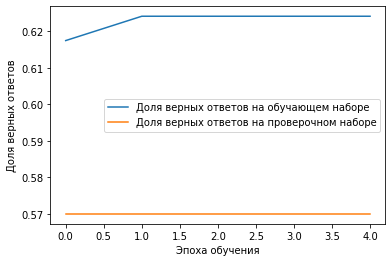

In [77]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [68]:
test_sequences = tokenizer.texts_to_sequences(df_test['Text'])

In [69]:
X_test = pad_sequences(test_sequences, maxlen=maxlen)
y_test = df_test['Class']

In [70]:
model.load_weights(model_save_path)
test_predict = model.predict(X_test)
test_predict = np.where(test_predict >= 0.5,1,0)

In [71]:
df_test['Class'] = test_predict
df_test.head()

,ID,Text,Class
0,1,ye bhi illegal immigrant lag rah hai arc regis...,1
1,2,yeah asked skirt today said ass like don't tim...,0
2,3,need clean selective hearing cobwebs ears tell...,0
3,4,easy complain criticize offering solution clos...,1
4,5,guess send-them-back policy friend hit little ...,1


In [72]:
df_test.drop('Text', axis=1).to_csv('test_lstm.csv', index=False, sep=',')

Kaggle ~0.8